In [3]:
!pip install pymesh

  Created wheel for pymesh: filename=pymesh-1.0.2-cp36-none-any.whl size=6918 sha256=a9dd57b655de30c593114f6e4d2502a03dc64590eb00b26ce52ad9f489a18f06
  Stored in directory: /root/.cache/pip/wheels/a6/d7/76/ed7121207ca5d4310797e72ae0921f54935d5afaf08bd67855
Successfully built pymesh


In [6]:
!pip install pybind11

  Using cached https://files.pythonhosted.org/packages/4b/4d/ae1c4d8e8b139afa9682054dd42df3b0e3b5c1731287933021b9fd7e9cc4/pybind11-2.4.3-py2.py3-none-any.whl


In [9]:
!pip install meshpy

  Using cached https://files.pythonhosted.org/packages/90/03/3bb205ac46141074aeb561f5bbf60fb2214380aa6ac1435b49d275cf219a/MeshPy-2018.2.1.tar.gz
  Created wheel for meshpy: filename=MeshPy-2018.2.1-cp36-cp36m-linux_x86_64.whl size=2785418 sha256=76de60154c398b36eb3be20b30999749804cf280381667cd1ea31f9b94bacf67
  Stored in directory: /root/.cache/pip/wheels/43/f6/00/0d863cde6a8531db3cab30dce6a6f86c7990188b2fe5e4bb2a
Successfully built meshpy


In [11]:
!pip install meshzoo

In [13]:
!pip install import_ipynb


  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2975 sha256=6667c4c3861024300ceda1a4f2dd571a8819ef4dedd081b277966d8d6b7f461b
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [0]:
import numpy as np
import pymesh 
from meshpy.triangle import MeshInfo, build
import meshzoo
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import import_ipynb
from scipy.spatial import Delaunay
#import Fast_marching_algorithm

In [0]:
def ray_tracing_numpy(x,y,poly):
    val = False
    if len(np.shape(x)) == 0:
        val = True
        x = np.array([x])
        y = np.array([y])
    n = len(poly)
    inside = np.zeros(len(x),np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y >= min(p1y,p2y)) & (y <= max(p1y,p2y)) & (x <= max(p1x,p2x)))[0]
        if p1y != p2y:
            xints = (y[idx]-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
        if p1x == p2x:
            inside[idx] = ~inside[idx]
        else:
            idxx = idx[x[idx] <= xints]
            inside[idxx] = ~inside[idxx]    

        p1x,p1y = p2x,p2y
    if val:
        inside = inside[0]
    return inside 

In [0]:
def data_for_FMA(nodes, n):
    x_min = min(nodes[:,0])
    x_max = np.max(nodes[:,0])
    y_min = np.min(nodes[:,1])
    y_max = np.max(nodes[:,1])
    N = len(nodes)
    d = np.linalg.norm(nodes[N-1]-nodes[0])/(n*N)
    for i in range(N-1):
        d += np.linalg.norm(nodes[i+1]-nodes[i])/(n*N)
    Nx = 3 + int((x_max-x_min)/d)
    Ny = 3 + int((y_max-y_min)/d)
    array = -np.ones((Ny,Nx))
    for j in range(Ny):
        for i in range(Nx):
            x = x_min + (i-1)*d
            y = y_min + (j-1)*d
            if ray_tracing_numpy(x,y,nodes):
                array[j,i] = 1
    #function = np.ones_like(array)/d
    return np.meshgrid(x_min-d+d*np.arange(Nx), y_min-d+d*np.arange(Ny)), array, d
            
        
    

In [0]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}

            
    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        if to_node not in self.edges[from_node]:
            self.edges[from_node].append(to_node)
            self.edges[to_node].append(from_node)
            self.distances[(from_node, to_node)] = distance
            self.distances[(to_node, from_node)] = distance
    def graph_from_nodes_and_cells(self, nodes, cells):
        for c in cells:
            self.add_node(c[0])
            self.add_node(c[1])
            self.add_node(c[2])
            self.add_edge(c[0],c[1],np.linalg.norm(nodes[c[0]]-nodes[c[1]]))
            self.add_edge(c[0],c[2],np.linalg.norm(nodes[c[0]]-nodes[c[2]]))
            self.add_edge(c[1],c[2],np.linalg.norm(nodes[c[1]]-nodes[c[2]]))


def dijkstra(graph, initial):
    far = set(graph.nodes)
    accepted = {}
    path = {}
    considered = {}
    for init_node in initial:
        accepted[init_node] = 0
        far.remove(init_node)
        for edge in graph.edges[init_node]:
            if edge not in initial and edge not in considered.keys():
                considered[edge] = graph.distances[(init_node, edge)]
                far.remove(edge)
                path[edge] = init_node
    while considered:
        #print(far)
        #print(considered)
        #print(accepted)
        min_node = None
        for node in considered:
            if min_node is None:
                min_node = node
            elif considered[node] < considered[min_node]:
                min_node = node
        if min_node == None:
            break
        accepted[min_node] = considered[min_node]
        del considered[min_node]
        current_weight = accepted[min_node]

   
        for edge in graph.edges[min_node]:
            try:
                weight = current_weight + graph.distances[(min_node, edge)]
            except:
                weight = current_weight + math.inf
            if (edge not in considered.keys() or weight < considered[edge]) and edge not in accepted.keys() :
                considered[edge] = weight
                path[edge] = min_node
                if edge not in considered:
                    far.remove(edge)
        
    distances = []
    for i in range(len(accepted)):
        distances.append(accepted[i])
    
    return distances
        
        

In [0]:
def solve_quadric(vec):
    D = vec[1]**2 - 4*vec[2]*vec[0]
    if vec[2] == 0:
        array = np.array([-vec[0]/vec[1]])
        return 1, array
    elif D < 0:
        return 0, []
    elif D==0:
        array = np.array([-vec[1]/(2*vec[2])])
        return 1, array
    else:
        array = -vec[1]/(2*vec[2])*np.ones(2)
        array += np.array([np.sqrt(D)/(2*vec[2]), -np.sqrt(D)/(2*vec[2])])
        return 2, array

class Fast_marching_algorithm:
    def __init__(self, points, function = [], high_acc = True):
        if len(function) == 0:
            self._function = np.ones_like(points)
        else:
            self._function = function
        self._high_acc = high_acc
        self._points = np.array(points)
        self._s0 = np.shape(points)[0]
        self._s1 = np.shape(points)[1]
        self.compute_N4()
        self.construct_values()
        self.construct_state_and_heap()
        
    def construct_values(self):
        self._fm = np.finfo('d').max
        values = self._fm*np.ones_like(self._points)
        for i in range(self._s0):
            for j in range(self._s1):
                if (i != 0 and i != self._s0-1 and self._points[i,j] == -1 and self._points[i-1,j]+ self._points[i+1,j] > -2) or (j != 0 and j != self._s1-1 and self._points[i,j] == -1 and self._points[i,j-1]+ self._points[i,j+1] > -2):
                    values[i,j] = 0
                elif i == 0 and self._points[i,j] == -1 and self._points[i+1, j] == 1:
                    values[i,j] = 0
                elif i == self._s0-1 and self._points[i,j] == -1 and self._points[i-1, j] == 1:
                    values[i,j] = 0
                elif j == 0 and self._points[i,j] == -1 and self._points[i, j+1] == 1:
                    values[i,j] = 0
                elif i == self._s1-1 and self._points[i,j] == -1 and self._points[i, j-1] == 1:
                    values[i,j] = 0
        self._values = values
    def construct_state_and_heap(self):
        self._heap = {}
        self._state = 2*np.ones_like(self._values)
        self._state[self._values == 0] = 0
        for i in range(self._s0):
            for j in range(self._s1):
                if self._state[i,j] == 0:
                    for dire in self._N4:
                        i0 = int(i + dire[0])
                        j0 = int(j + dire[1])
                        if self.check_inside(i0, j0) and self._state[i0, j0] != 0:
                            self._state[i0, j0] = 1
                            comp = self.compute(i0, j0)
                            if comp[0]:
                                self._heap[i0*self._s1 + j0] = comp[1]
    def compute_N4(self):
        self._N4 = np.zeros((4,2))
        self._N4[0,0] = 1
        self._N4[1,0] = -1
        self._N4[2,1] = 1
        self._N4[3,1] = -1
    def check_inside(self, i, j):
        if i >= 0 and i <= self._s0-1 and j >= 0 and j <= self._s1-1:
            return True
        return False
    def compute(self, i, j):
        coef = np.array([-1.0/self._function[i,j]**2, 0, 0])
        pi = np.array([i,j])
        for k in range(2):
            val1 = self._fm
            val2 = self._fm
            for l in range(2):
                pni = (pi+self._N4[2*k+l]).astype(int)
                if self.check_inside(pni[0],pni[1]):
                    _val1 = self._values[pni[0],pni[1]]
                    if self._state[pni[0],pni[1]] == 0 and _val1 < val1:
                        val1 = _val1
                        pni2 =(pi + 2*self._N4[2*k+l]).astype(int)
                        if self.check_inside(pni2[0],pni2[1]):
                            _val2 = self._values[pni2[0], pni2[1]]
                            if self._state[pni2[0],pni2[1]] == 0 and _val2 <= _val1:
                                val2 = _val2
            if self._high_acc and val2 != self._fm:
                tp = (1/3)*(4*val1 - val2)
                a = 9/4
                coef += np.array([a*np.sqrt(tp), - 2*a*tp, a])
            elif val1 != self._fm:
                coef += np.array([np.sqrt(val1), -2*val1, 1])
        max_sol = self._fm
        sol = max_sol * np.ones(2)
        nb_sol, sol = solve_quadric(coef)
        if nb_sol:
            if nb_sol == 2:
                max_sol = np.max(sol)
            else:
                max_sol = sol[0]
            if max_sol < self._values[i,j]:
                self._values[i,j] = max_sol
                return [True, max_sol]
        return [False]
    def __call__(self):
        while len(self._heap) != 0:
            p = min(self._heap, key = self._heap.get)
            del self._heap[p]
            i = p//self._s1
            j = p%self._s1
            self._state[i, j] = 0
            for dire in self._N4:
                i0 = int(i + dire[0])
                j0 = int(j + dire[1])
                if self.check_inside(i0, j0) and self._state[i0,j0] != 0:
                    self._state[i0, j0] = 1
                    comp = self.compute(i0, j0)
                    if comp[0]:
                        self._heap[i0*self._s1 + j0] = comp[1]
                    
        return self._values

In [0]:
import random
triangleInput = [[0,0],[1,3],[5,3]]

n = 4
points = []




In [0]:
def build_mesh(points, n=1):
    points = np.array(points)
    P = n**2*(len(points)-2)#the number of points
    R2_to_R = lambda x: round(x[0]*P + x[1],5)# We need correspondance of a vector in R2 to a single value: (x,y) -> x*P + y
    facets = []#the set of polygon edges
    boundary_nodes_values = [] # the list of values corresponding to the contour nodes
    for i in range(len(points)-1):
        facets.append([i, i+1])#We assume that 'points' is given in the traversal order of the polygon outline 
        for j in range(n):# each edge will have n mesh nodes  
            d = np.array(points[i]) + (j/n)*(np.array(points[i+1]) - np.array(points[i]))
            boundary_nodes_values.append(R2_to_R(d))
    facets.append([len(points)-1, 0])
    for j in range(n):
        d = np.array(points[len(points)-1]) + (j/n)*(np.array(points[0]) - np.array(points[len(points)-1]))
        boundary_nodes_values.append(R2_to_R(d))
    mesh_info = MeshInfo()#we use meshpy to divide our domain into triangles
    mesh_info.set_points(points)
    mesh_info.set_facets(facets)
    mesh = build(mesh_info)#mesh of big triangles has points and elements(these big triangles represented by serial numbers of three nodes)
    all_nodes_values = []
    nodes_all = []
    cells_all = []

    for e in mesh.elements:
        
        nodes, cells = meshzoo.triangle(n, corners = np.array(mesh.points)[np.array(e)])# we divide each
        # big triangle into n^2 small triangles using meshzoo
        # 'cells' is the array of small triangles(each is represented by serial numbers of three nodes)
        nodes_dict = {} # dictionary of nodes 
        #{local(in current big triangle) serial number: global(in the whole domain) serial number}
        for i, node in enumerate(nodes):#loop over nodes 
            node_val = R2_to_R(node)
            if node_val not in all_nodes_values:#check if this node is not already in the array of all nodes
                all_nodes_values.append(round(node_val,5))
                nodes_all.append(node)
                nodes_dict[i] = len(nodes_all)-1
            else:
                nodes_dict[i] = all_nodes_values.index(node_val)
        for c in cells:
            cells_all.append([nodes_dict[c[0]],nodes_dict[c[1]],nodes_dict[c[2]]])
            #add each small triangle as three global serial numbers of nodes 
    boundary_nodes = []# the list of global serial numbers corresponding to the contour nodes
    for node_val in boundary_nodes_values:#we convert nodes values into serial numbers 
        boundary_nodes.append(all_nodes_values.index(node_val))
    nodes_all = np.array(nodes_all)
    cells_all = np.array(cells_all)
    g = Graph()
    g.graph_from_nodes_and_cells(nodes_all, cells_all)
    dij_dist = dijkstra(g, boundary_nodes)
    
    (x, y), array, d = data_for_FMA(points, n)
    FM = Fast_marching_algorithm(array, high_acc=False)
    FM_dist = FM() * d
    
    #print(np.max(FM_dist))
    #print(np.max(dij_dist))
    #print(FM_dist)
    #print(dij_dist)
    #print(array)
    #print(function)
    #print(FM._state)
    #print(FM._heap)
    #print(x)
    #print(y)
    
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,10))
    triang = mtri.Triangulation(nodes_all[:,0], nodes_all[:,1], cells_all)
    
    ax1.tricontourf(triang, dij_dist)
    ax1.triplot(triang, 'ko-', lw = 0.5, alpha=0.5)
    ax1.set_title('Triangular grid and Dijkstra algorithm')
    ax1.set_xlim(x[0,0],x[-1,-1])
    ax1.set_ylim(y[0,0],y[-1,-1])
    
    dist  = np.ma.array(FM_dist, mask=(array<0))# + (FM_dist == 0))
    ax2.contourf(x, y, dist)
    ax2.plot(x, y, 'k-', lw=0.5, alpha=0.5)
    ax2.plot(x.T, y.T, 'k-', lw=0.5, alpha=0.5)
    ax2.set_title("Quadrilateral grid and FM-algorithm")
    
    return nodes_all, cells_all, dij_dist, FM_dist          
        

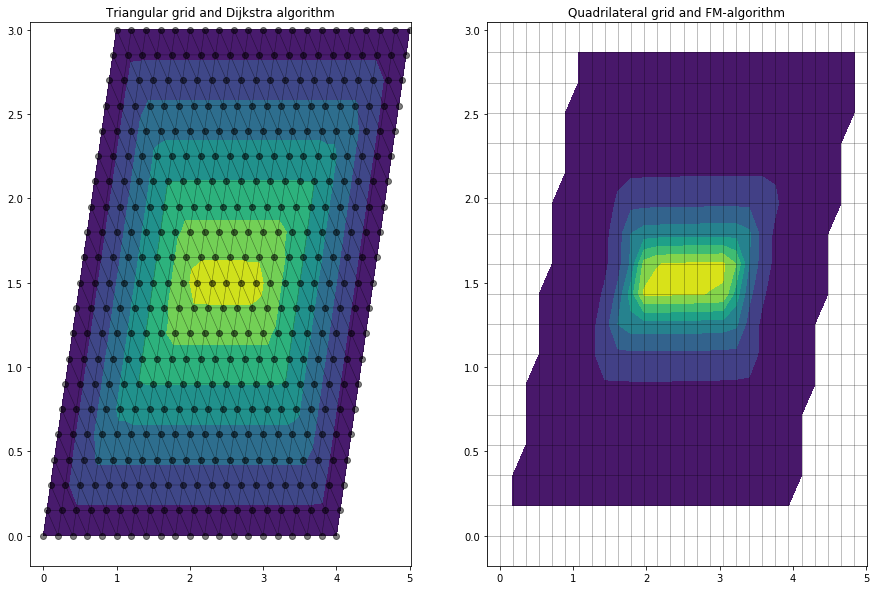

In [117]:
nod, cel, dist1, dist2 = build_mesh([[0,0],[1,3],[5,3],[4,0]], 20)
#print(nod)
#print(cel)
#print(dist)

In [0]:
def build_irregular_mesh(points, n=1):
    points = np.array(points)
    P = n**2*(len(points)-2)#the number of points
    R2_to_R = lambda x: round(x[0]*P + x[1],5)# We need correspondance of a vector in R2 to a single value: (x,y) -> x*P + y
    facets = []#the set of polygon edges
    boundary_nodes_values = [] # the list of values corresponding to the contour nodes
    for i in range(len(points)-1):
        facets.append([i, i+1])#We assume that 'points' is given in the traversal order of the polygon outline 
        for j in range(n):# each edge will have n mesh nodes  
            d = np.array(points[i]) + (j/n)*(np.array(points[i+1]) - np.array(points[i]))
            boundary_nodes_values.append(R2_to_R(d))
    facets.append([len(points)-1, 0])
    for j in range(n):
        d = np.array(points[len(points)-1]) + (j/n)*(np.array(points[0]) - np.array(points[len(points)-1]))
        boundary_nodes_values.append(R2_to_R(d))
    mesh_info = MeshInfo()#we use meshpy to divide our domain into triangles
    mesh_info.set_points(points)
    mesh_info.set_facets(facets)
    mesh = build(mesh_info)#mesh of big triangles has points and elements(these big triangles represented by serial numbers of three nodes)
    all_nodes_values = []
    nodes_all = []
    cells_all = []

    points= []#added
    nodes = []#added
    cells = []#added
    numberPointsDelaunayTriangulation = 10
    print(len(mesh.elements))
    for i in range(len(mesh.elements)-1):
#instead of regular triangles we want to use Delaunay triangulation
        print('before')
        print(mesh.elements)
        print('after')
        for j in range(numberPointsDelaunayTriangulation-1):
          s=random.random()
          t=random.random()
          print(mesh.elements[i][0])
          print(mesh.elements[i][1])
          print(mesh.elements[i][2])
          Px = (1-t) * mesh.points[mesh.elements[i][0]][0] + t * ((1-s) * mesh.points[mesh.elements[i][1]][0] + s* mesh.points[mesh.elements[i][2]][0])
          Py = (1-t) * mesh.points[mesh.elements[i][0]][1] + t * ((1-s) * mesh.points[mesh.elements[i][1]][1] + s* mesh.points[mesh.elements[i][2]][1])
          points.append([Px,Py])

        tri = Delaunay(points)
        nodes.append(tri.points)
        cells.append(tri.simplices)

        for i, node in enumerate(nodes):#loop over nodes 
            node_val = R2_to_R(node)
            if node_val not in all_nodes_values:#check if this node is not already in the array of all nodes
                all_nodes_values.append(round(node_val,5))
                nodes_all.append(node)
                nodes_dict[i] = len(nodes_all)-1
            else:
                nodes_dict[i] = all_nodes_values.index(node_val)
        for c in cells:
            cells_all.append([nodes_dict[c[0]],nodes_dict[c[1]],nodes_dict[c[2]]])


    boundary_nodes = []# the list of global serial numbers corresponding to the contour nodes
    for node_val in boundary_nodes_values:#we convert nodes values into serial numbers 
        boundary_nodes.append(all_nodes_values.index(node_val))
    nodes_all = np.array(nodes_all)
    cells_all = np.array(cells_all)
    g = Graph()
    g.graph_from_nodes_and_cells(nodes_all, cells_all)
    dij_dist = dijkstra(g, boundary_nodes)
    
    (x, y), array, d = data_for_FMA(points, n)
    FM = Fast_marching_algorithm(array, high_acc=False)
    FM_dist = FM() * d
    
    #print(np.max(FM_dist))
    #print(np.max(dij_dist))
    #print(FM_dist)
    #print(dij_dist)
    #print(array)
    #print(function)
    #print(FM._state)
    #print(FM._heap)
    #print(x)
    #print(y)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,10))
    triang = mtri.Triangulation(nodes_all[:,0], nodes_all[:,1], cells_all)
    
    ax1.tricontourf(triang, dij_dist)
    ax1.triplot(triang, 'ko-', lw = 0.5, alpha=0.5)
    ax1.set_title('Triangular grid and Dijkstra algorithm')
    ax1.set_xlim(x[0,0],x[-1,-1])
    ax1.set_ylim(y[0,0],y[-1,-1])
    
    dist  = np.ma.array(FM_dist, mask=(array<0))# + (FM_dist == 0))
    ax2.contourf(x, y, dist)
    ax2.plot(x, y, 'k-', lw=0.5, alpha=0.5)
    ax2.plot(x.T, y.T, 'k-', lw=0.5, alpha=0.5)
    ax2.set_title("Quadrilateral grid and FM-algorithm")
    
    return nodes_all, cells_all, dij_dist, FM_dist          

In [124]:
nod, cel, dist1, dist2 = build_irregular_mesh([[0,0],[1,3],[5,3],[4,0]], 20)
#print(nod)
#print(cel)
#print(dist)

2
before
after
1
0
3
1
0
3
1
0
3
1
0
3
1
0
3
1
0
3
1
0
3
1
0
3
1
0
3


TypeError: ignored

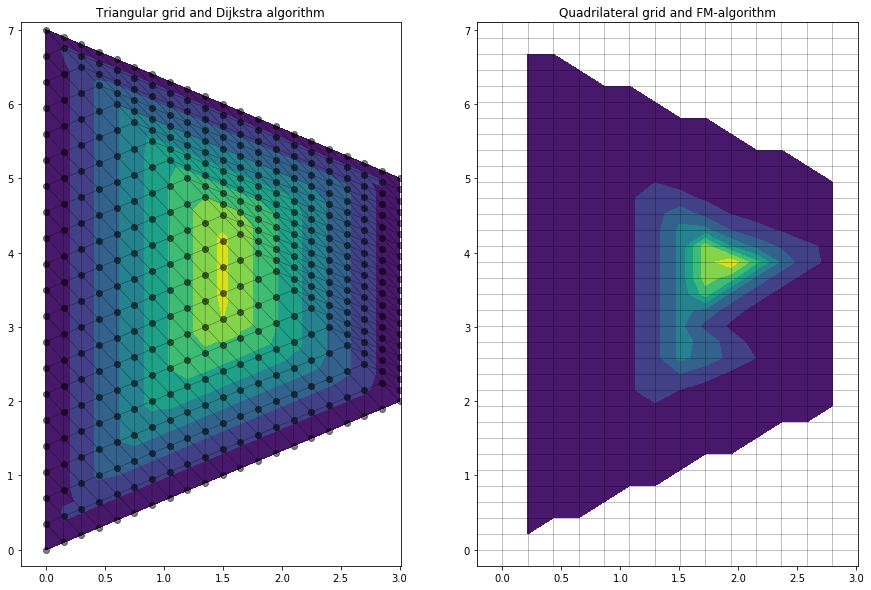

In [25]:
nod, cel, dist1, dist2 = build_mesh([[0,7],[3,5],[3,2], [0,0]], 20)
#print(dist)

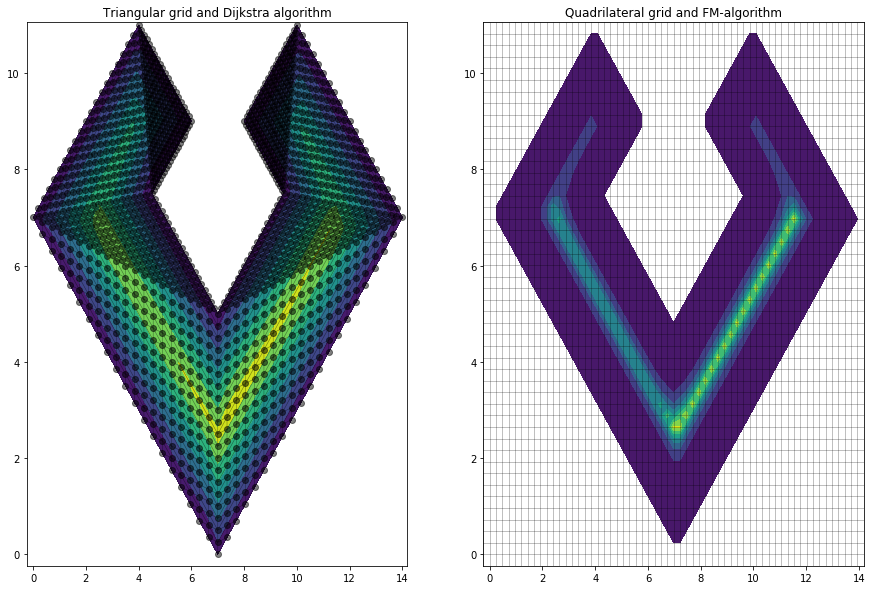

In [26]:
domain_nodes = [[0,7],[4,11],[6,9],[4.5,7.5],[7,5],[9.5,7.5],[8,9],[10,11],[14,7],[7,0]]
nod, cel, dist1, dist2 = build_mesh(domain_nodes, 20)



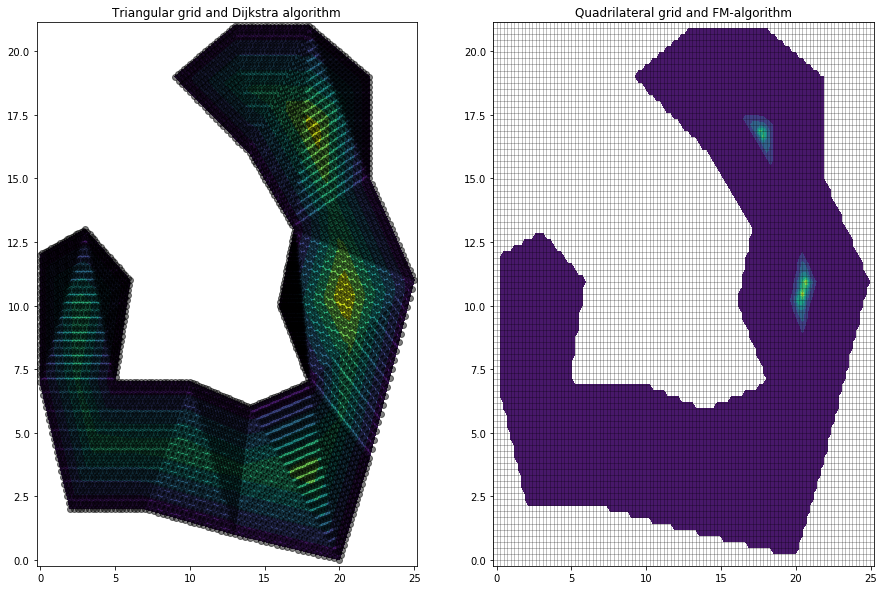

In [27]:
domain_nodes = [[0,12],[3,13],[6,11],[5,7],[10,7],[14,6],[18,7],[16,10],[17,13],[14,16],[9,19],[13,21],[18,21],[22,19],[22,15],[25,11],[22,4],[20,0],[13,1],[7,2],[2,2],[0,7]]
nod, cel, dist1, dist2 = build_mesh(domain_nodes, 20)